# Full Data Processing Pipeline in Jupyter

## Import RHD recordings and concatenate
We assume they are in the same folder and have date & time in their filenames, 
so we can sort them in a proper order, but it's for users to ensure the continuity.

Here, you can select a start file and end file, and in the next cell, the RHD files will
be loaded and concantenated.

In [1]:
from pathlib import Path

# find all rhd files in a folder by a pattern
rhd_dir = Path(r'D:\Wechat\WeChat Files\wxid_dy802x8wpmoa21\FileStorage\File\2023-08')
rhd_files = [i.name for i in rhd_dir.glob('*.rhd')]
rhd_files.sort()

# GUI
import ipywidgets as widgets
start_rhd = widgets.Dropdown(
        options=rhd_files,
        value=rhd_files[0]
    )
end_rhd = widgets.Dropdown(
        options=rhd_files,
        value=rhd_files[-1],
    )

def file_count(start, end):
    s = rhd_files.index(start)
    e = rhd_files.index(end)
    print(f'Selection check: {e - s + 1} RHD files will be loaded.')
    
out = widgets.interactive_output(file_count, {'start': start_rhd, 'end': end_rhd})

widgets.VBox([
    widgets.TwoByTwoLayout(
    top_left=widgets.Label('Starting RHD file:'),
    bottom_left=start_rhd,
    top_right=widgets.Label('Ending RHD file:'),
    bottom_right=end_rhd,
), out
])


---
Load the selected files and concatenate them. We only load the `RHD2000 amplifier channel` from each file. This stream name
might differ for different experiments.

In [2]:
from spikeinterface import concatenate_recordings
import spikeinterface.extractors as se
rec = []
a, b = rhd_files.index(start_rhd.value), rhd_files.index(end_rhd.value) + 1

# GUI
import ipywidgets as widgets
prog = widgets.IntProgress(
    value=0,
    min=0,
    max=b-a,
    bar_style='success',
    style={'bar_color': 'maroon'},
    orientation='horizontal', 
)
def file_count(prog):
    print(f'{prog}/{b-a} loaded.')
out = widgets.interactive_output(file_count, {'prog': prog})
display(widgets.TwoByTwoLayout(
    top_left=widgets.Label('Loading RHD progress..'),
    bottom_left=prog,
    bottom_right=out,
    merge=False
))

# load and concatenate
for i in rhd_files[a:b]:
    rec.append(se.read_intan(rhd_dir / i, stream_name='RHD2000 amplifier channel'))
    prog.value += 1
rec = concatenate_recordings(rec)

TwoByTwoLayout(children=(Label(value='Loading RHD progress..', layout=Layout(grid_area='top-left')), IntProgre…

# Preprocessing

Here, we execute 5 preprocessing steps for our data:
1. filter bad channels based on measure impedance level
2. filter bad channels using `spikeinterface`'s neighborhood_r2 method
3. applying butterworth bandpass filter
4. re-reference the signal
5. clean machenical noise using our own method

Some of them can be optional, like step 5, because `spikeinterface` and Kilosort2.5 have their way to do this.

Bad channel filtering is recommended, but can be flexible. Step 1 is based on a priori information, while step 2 is based on the waveform itself. `spikeinterface` by default uses IBL's method, which assumes the probe to be like a rigid needle as neuropixel is, not applying to our case.

Step 3 & 4 are rather like highpass filtering in time and space respectively. Since our probe can be large in size, re-referencing should be done.

*The cells in this part are coded in a way you can optionally run each step, and check their waveforms*

In [82]:
# the result will be stored and updated in this variable, also add the probe here
# rerun this if you need to reset the preprocessing workflow
from probe import my_probe
preproc = rec.set_probe(my_probe())

None
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1']


### inspect the waveform
You can always come back and run this section to see how the waveform changes.

In [2]:
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
@widgets.interact(start_time=(0, preproc.get_duration()), end_time=(0, preproc.get_duration()), 
                  start_channel=(0, preproc.get_num_channels()), end_channel=(0, preproc.get_num_channels()-1))
def plot_ts(start_time=0, end_time=10, start_channel=0, end_channel=15, show_channel_ids=True):
    channels = preproc.get_channel_ids()[start_channel: end_channel+1]
    sw.plot_timeseries(preproc, channel_ids=channels, time_range=(start_time, end_time), add_legend=False, show_channel_ids=show_channel_ids)

NameError: name 'widgets' is not defined

### 1. filter by impedance
Based on the impedance magnitude of each electrode, and set an upper threshold for them.

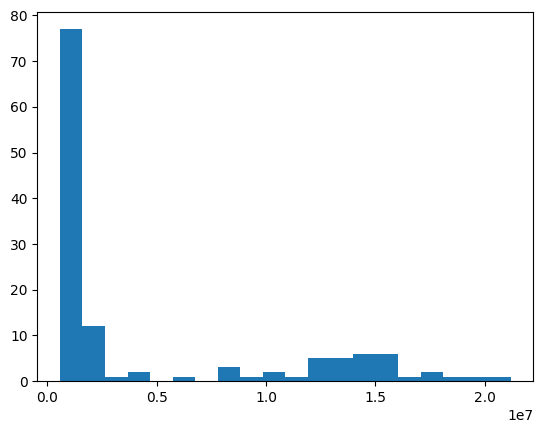

FloatText(value=5000000.0, description='Impedance cap:', style=DescriptionStyle(description_width='initial'))

In [72]:
import pandas as pd

# our impedance table
imped_tab = pd.read_csv(r"D:\Wechat\WeChat Files\wxid_dy802x8wpmoa21\FileStorage\File\2023-08\IMP.csv")
names = []
for i in imped_tab['Channel Name']:
    id = 0 if i.startswith('A') else 64
    id += int(i.split('-')[1])
    names.append(str(id))
imped_tab = imped_tab['Impedance Magnitude at 1000 Hz (ohms)']
imped_tab.index = names

import matplotlib.pyplot as plt
plt.hist(imped_tab, bins=20)
plt.show()
impedance_thr = widgets.FloatText(description='Impedance cap:', value=0.5e7, style={'description_width': 'initial'})
display(thr)

In [83]:
preproc = preproc.remove_channels([i for i in preproc.get_channel_ids() if imped_tab[i] > impedance_thr.value])
preproc  # show the number of channels left

ChannelSliceRecording: 92 channels - 20.0kHz - 1 segments - 3,601,920 samples 
                       180.10s (3.00 minutes) - uint16 dtype - 632.05 MiB

### 2. filter by neighborhood
There are many parameters for this function in `spikeinterface`, here we provide you with a simple UI.
Note that this can only be done with channels' spatial locations, and you need to specify the probe setting for this.

In [74]:
grid = widgets.GridspecLayout(2, 3)
grid[0, 0] = widgets.FloatSlider(description='r2 thr', value=.95, min=0, max=1, step=.01)
grid[0, 1] = widgets.FloatText(description='radius (um)', value=30)
grid[0, 2] = widgets.FloatText(description='highpass cutoff', value=300, style={'description_width': 'initial'})
grid[1, 0] = widgets.IntText(description='#rand chunk', value=10)
grid[1, 1] = widgets.FloatText(description='welch window (ms)', value=10, style={'description_width': 'initial'})
grid[1, 2] = widgets.FloatText(description='chunk duration (s)', value=.3, style={'description_width': 'initial'})
display(grid)

GridspecLayout(children=(FloatSlider(value=0.95, description='r2 thr', layout=Layout(grid_area='widget001'), m…

In [84]:
import spikeinterface.preprocessing as spre
bd, lb = spre.detect_bad_channels(preproc, 'neighborhood_r2',
                                  neighborhood_r2_threshold=grid[0, 0].value,
                                  neighborhood_r2_radius_um=grid[0, 1].value,
                                  highpass_filter_cutoff=grid[0, 2].value,
                                  num_random_chunks=grid[1, 0].value,
                                  welch_window_ms=grid[1, 1].value,
                                  chunk_duration_s=grid[1, 2].value)
preproc = preproc.remove_channels(bd)
preproc

ChannelSliceRecording: 92 channels - 20.0kHz - 1 segments - 3,601,920 samples 
                       180.10s (3.00 minutes) - uint16 dtype - 632.05 MiB

### 3. butterworth bandpass filter

In [81]:
lp = widgets.FloatText(description='low pass cutoff', value=250, style={'description_width': 'initial'})
hp = widgets.FloatText(description='high pass cutoff', value=6000, style={'description_width': 'initial'})
order = widgets.IntText(description='order', value=4)
iter = widgets.IntText(description='iteration', value=1)

widgets.TwoByTwoLayout(
    top_left=lp, top_right=hp, bottom_left=order, bottom_right=iter
)

TwoByTwoLayout(children=(FloatText(value=250.0, description='low pass cutoff', layout=Layout(grid_area='top-le…

In [86]:
for i in range(iter.value):
    preproc = spre.filter(preproc, [lp.value, hp.value], 'bandpass', order.value)
preproc

FilterRecording: 92 channels - 20.0kHz - 1 segments - 3,601,920 samples - 180.10s (3.00 minutes) 
                 int16 dtype - 632.05 MiB

### 4. re-reference
There are 2 operators (median/average) to compute the referencing and 3 modes for the reference (glboal/local/single), but here
we don't consider single for our probe and thus there is no need to specify the channels.

When you choose the 'local' mode, you will need the input of the 2 radius to include and exclude the surrounding electrodes.

Neuropixel data would use a phase_shift before re-referencing and mechanical drift detection, but since we have no information about the sampling delay for each electrode, this is left undone.

In [88]:
op = widgets.Dropdown(description='operator', value='median', options=['average', 'median'])
ref = widgets.Dropdown(description='reference', value='global', options=['global', 'local'])
local_r1 = widgets.IntText(description='local exclude radius', value=30, style={'description_width': 'initial'})
local_r2 = widgets.IntText(description='local include radius', value=55, style={'description_width': 'initial'})

widgets.TwoByTwoLayout(
    top_left=op, top_right=ref, bottom_left=local_r1, bottom_right=local_r2
)

TwoByTwoLayout(children=(Dropdown(description='operator', index=1, layout=Layout(grid_area='top-left'), option…

In [92]:
preproc = spre.common_reference(preproc, operator=op.value, reference=ref.value, local_radius=(local_r1.value, local_r2.value))
preproc

CommonReferenceRecording: 92 channels - 20.0kHz - 1 segments - 3,601,920 samples 
                          180.10s (3.00 minutes) - int16 dtype - 632.05 MiB

### 5. clean mechanical noise

This is a self-defined and optional step. We use a very simple method that first average all the channel and then check the max autocorrelation of each interval and clear parts exceeding a multiple of the median autocorrelation. `spikeinterface` uses sophisticated method to decide whether to do the correction and interpolate the frames.

In [104]:
window = widgets.IntText(description='window', value=2000)
interval = widgets.IntText(description='interval', value=200)
noise_cap = widgets.FloatText(description='noise cap', value=2.5)

widgets.TwoByTwoLayout(
    top_left=window, top_right=interval, bottom_left=noise_cap, merge=False
)

TwoByTwoLayout(children=(IntText(value=2000, description='window', layout=Layout(grid_area='top-left')), IntTe…

In [147]:
import numpy as np
from numba import njit, prange


@njit(parallel=True, fastmath=True)
def get_mech_noise(data, mov_window, interval):
    mov_ccnoise = np.zeros_like(data)
    for j in prange(data.shape[0] // interval):
        i = j * interval
        idx0 = max(0, i + (interval - mov_window) // 2)
        idx1 = min(data.shape[0], i + (interval + mov_window) // 2)
        v = data[idx0: idx1]
        mov_ccnoise[i: i + interval] = np.correlate(v, v).max()
    mov_ccnoise = (mov_ccnoise - mov_ccnoise.min()) / (mov_ccnoise.max() - mov_ccnoise.min())
    return mov_ccnoise


tr = preproc.get_traces()
ref_data = np.mean(tr, axis=1)  # compute average across channels

mov_ccnoise = get_mech_noise(ref_data, window.value, interval.value)
tr[mov_ccnoise > np.median(mov_ccnoise) * noise_cap.value] = 0

preproc = se.NumpyRecording(tr, preproc.get_sampling_frequency(), [0], preproc.get_channel_ids()).set_probe(preproc.get_probe())
preproc

NumpyRecording: 92 channels - 20.0kHz - 1 segments - 3,601,920 samples - 180.10s (3.00 minutes) 
                int16 dtype - 632.05 MiB

### save the recording

In [ ]:
job_kwargs = dict(n_jobs=10, chunk_duration='1s', progress_bar=True)
base_folder = Path('data')
preproc = preproc.save(folder=base_folder / 'preprocess', format='binary', **job_kwargs)

write_binary_recording with n_jobs = 10 and chunk_size = 20000


## Spike sorting (Kilosort 2.5)

In [1]:
sorting_KS2 = ss.run_sorter(sorter_name="kilosort2_5", recording=preproc)

1